In [1]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
num_layers = [1,2,3]
suffix = ['', '_ctx']
instance = ['', '_1']
runs_dfs = {}
for layer in num_layers:
    for suf in suffix:
        for inst in instance:
            run_name = f'{layer}_layers{suf}{inst}'
            # Initialize an EventAccumulator

            event_acc = EventAccumulator(f'/home/niv.ko/MACAW/8_tasks_log/{run_name}/tb')

            # Load the data to the EventAccumulator
            event_acc.Reload()

            # Get the scalar data
            df = pd.DataFrame()
            for tag in event_acc.Tags()["scalars"]:
                if 'Eval' in tag:
                    events = event_acc.Scalars(tag)
                    data = [(e.step, e.value) for e in events]
                    if df.index.size == 0:
                        df.index = [e[0] for e in data]
                    df[tag] = [e[1] for e in data]


            runs_dfs[run_name] = df

/data/user-data/niv.ko/miniconda3/envs/mac-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/user-data/niv.ko/miniconda3/envs/mac-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/user-data/niv.ko/miniconda3/envs/mac-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/user

In [3]:
mean_dfs = {}
for layer in num_layers:
    for suf in suffix:
        instances_dfs = []
        for inst in instance:
            run_name = f'{layer}_layers{suf}{inst}'
            instances_dfs.append(runs_dfs[run_name])
        mean_df = pd.concat(instances_dfs).groupby(level=0).mean()
        mean_dfs[f'{layer}_layers{suf}'] = mean_df

In [5]:
mean_dfs['1_layers_ctx'].head()

,Eval_Reward/Task_19,Eval_Reward_FT/Task_19,Eval_Success/Task_19,Eval_Success_FT/Task_19,Eval_Reward/Task_18,Eval_Reward_FT/Task_18,Eval_Success/Task_18,Eval_Success_FT/Task_18,Eval_Reward/Task_17,Eval_Reward_FT/Task_17,...,Eval_Success/Task_2,Eval_Success_FT/Task_2,Eval_Reward/Task_1,Eval_Reward_FT/Task_1,Eval_Success/Task_1,Eval_Success_FT/Task_1,Eval_Reward/Mean,Eval_Success/Mean,Eval_Reward_FT/Mean,Eval_Success_FT/Mean
0,-300.751587,-300.751587,0.0,0.0,-286.677521,-286.677521,0.0,0.0,-271.195740,-271.195740,...,0.0,0.0,-31.821312,-31.821312,0.0,0.0,-166.204979,0.0,-166.204979,0.0
250,-314.065277,-314.065277,0.0,0.0,-297.284561,-297.284561,0.0,0.0,-283.091415,-283.091415,...,0.0,0.0,-45.865667,-45.865667,0.0,0.0,-178.739983,0.0,-178.739983,0.0
500,-303.887375,-303.887375,0.0,0.0,-301.373810,-301.373810,0.0,0.0,-273.009613,-273.009613,...,0.0,0.0,-52.379751,-52.379751,0.0,0.0,-180.558403,0.0,-180.558403,0.0
750,-279.467606,-279.467606,0.0,0.0,-302.288757,-302.288757,0.0,0.0,-286.828491,-286.828491,...,0.0,0.0,-51.377520,-51.377520,0.0,0.0,-178.918686,0.0,-178.918686,0.0
1000,-284.757103,-284.757103,0.0,0.0,-299.262848,-299.262848,0.0,0.0,-286.490082,-286.490082,...,0.0,0.0,-48.934799,-48.934799,0.0,0.0,-177.114075,0.0,-177.114075,0.0


In [27]:
def smooth_series(series, window_size=3):
    # Calculate the rolling mean using the Pandas built-in function
    smoothed_data = series.rolling(window=window_size, center=True).mean()
    
    # Drop NaN values which represent the problematic edges
    smoothed_data = smoothed_data.dropna()
    
    return smoothed_data

In [58]:
def annot_max(vecs, ax):
    ymax = -np.inf
    for vec in vecs:
        y = vec.values
        x = vec.index
        if y.max() > ymax:
            ymax = y.max()
            xmax = x[np.argmax(y)]
        
    text= "x={}, y={:.3f}".format(int(xmax), ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

In [61]:
def plot_smoothed(vecs, labels, win_size, title, x_label, y_label, save=False):
    fig, ax = plt.subplots()
    smoothed_vecs = [smooth_series(vec, win_size) for vec in vecs]
    for smoothed_vec, label in zip(smoothed_vecs, labels):
        ax.plot(smoothed_vec.index, smoothed_vec, label=label)
    annot_max(smoothed_vecs, ax)
    ax.legend(loc='center right')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_ylim(-150,-50)
    if save:
        plt.savefig(f'/home/niv.ko/MACAW/{title}.png')
    plt.show()

In [29]:
full_layers_dfs = {}
only_ctx_dfs = {}
for key, df in mean_dfs.items():
    label = key.replace('_', ' ')
    label = label.replace('1 layers', '1 layer')
    if 'ctx' in key:
        only_ctx_dfs[label] = df
    else:
        full_layers_dfs[label] = df

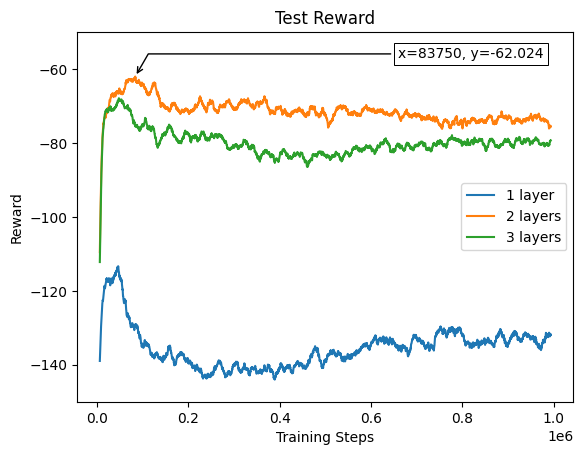

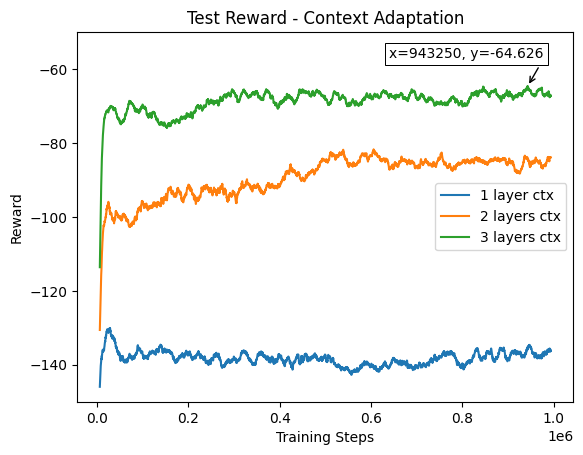

In [62]:
x_label = 'Training Steps'
y_label = 'Reward'
title = 'Test Reward'
full_layers_labels, full_layers_vecs = zip(*((k, df['Eval_Reward/Mean']) for k, df in full_layers_dfs.items()))
plot_smoothed(full_layers_vecs, full_layers_labels, 50, title, x_label, y_label,  save=True)

only_ctx_labels, only_ctx_vecs = zip(*((k, df['Eval_Reward/Mean']) for k, df in only_ctx_dfs.items()))
plot_smoothed(only_ctx_vecs, only_ctx_labels, 50, title + ' - Context Adaptation', x_label, y_label,  save=True)

In [14]:
print(mean_dfs['1_layers_ctx'].columns)

Index(['Eval_Reward/Task_19', 'Eval_Reward_FT/Task_19', 'Eval_Success/Task_19',
       'Eval_Success_FT/Task_19', 'Eval_Reward/Task_18',
       'Eval_Reward_FT/Task_18', 'Eval_Success/Task_18',
       'Eval_Success_FT/Task_18', 'Eval_Reward/Task_17',
       'Eval_Reward_FT/Task_17', 'Eval_Success/Task_17',
       'Eval_Success_FT/Task_17', 'Eval_Reward/Task_15',
       'Eval_Reward_FT/Task_15', 'Eval_Success/Task_15',
       'Eval_Success_FT/Task_15', 'Eval_Reward/Task_14',
       'Eval_Reward_FT/Task_14', 'Eval_Success/Task_14',
       'Eval_Success_FT/Task_14', 'Eval_Reward/Task_13',
       'Eval_Reward_FT/Task_13', 'Eval_Success/Task_13',
       'Eval_Success_FT/Task_13', 'Eval_Reward/Task_11',
       'Eval_Reward_FT/Task_11', 'Eval_Success/Task_11',
       'Eval_Success_FT/Task_11', 'Eval_Reward/Task_10',
       'Eval_Reward_FT/Task_10', 'Eval_Success/Task_10',
       'Eval_Success_FT/Task_10', 'Eval_Reward/Task_9',
       'Eval_Reward_FT/Task_9', 'Eval_Success/Task_9',
       'Eva

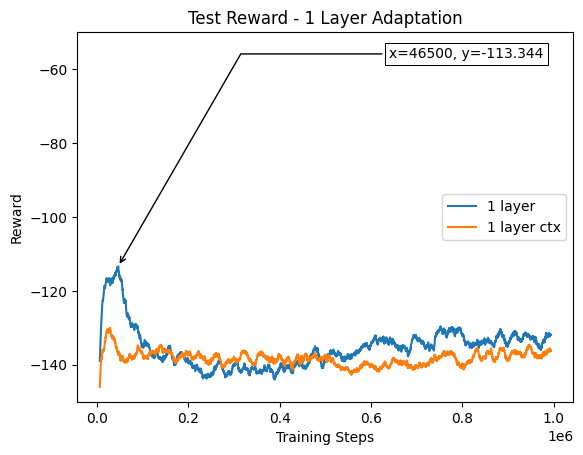

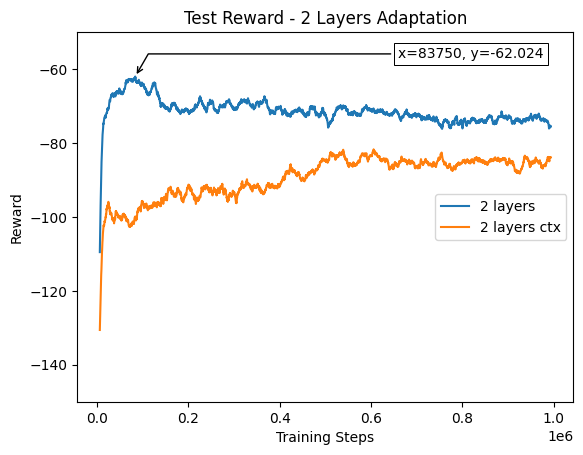

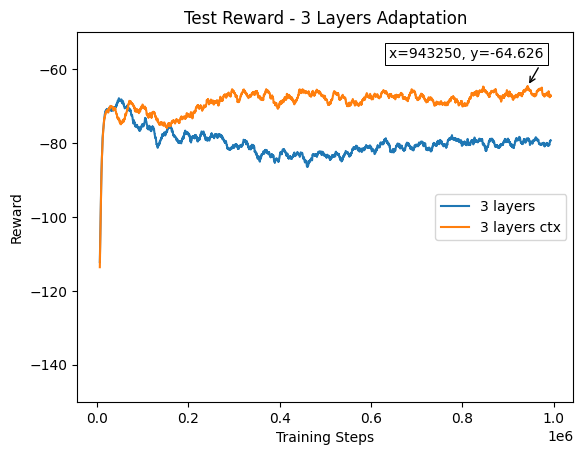

In [63]:
for n in range(1,4):
    all_dfs = {**full_layers_dfs, **only_ctx_dfs}
    dfs = [(k, df[f'Eval_Reward/Mean']) for k, df in all_dfs.items() if f'{n}' in k]
    labels, vecs = zip(*dfs)
    title_suf = f' - {n} Layers Adaptation' if n > 1 else f' - {n} Layer Adaptation'
    plot_smoothed(vecs, labels, 50, title + title_suf, x_label, y_label,  save=True)